In [8]:
import numpy as np

%matplotlib inline

import pandas as pd
import seaborn as sns

Below, we define functions that construct a Gibbs sampler for a simple Bayesian linear regression problem involving two variables B0 and B1.

yi = B0 + B1 * xi

See additional details in the notion notebook I've created, or here: https://kieranrcampbell.github.io/blog/2016/05/15/gibbs-sampling-bayesian-linear-regression.html

In [36]:
#Check notion notebook for derivation of the Gibbs sampler

def sample_beta_0_marg_post(x, y, beta_1, tau, tau_0, mu_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + N * tau
    mu = (tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)) / precision

    return np.random.normal(mu, 1 / np.sqrt(precision))

In [37]:
#We'll also define a function to sample beta_1 from its marginal posterior distribution.
def sample_beta_1_marg_post(x,y,beta_0, tau, tau_1, mu_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mu = (tau_1 * mu_1 + tau * np.sum((y - beta_0) * x)) / precision

    return np.random.normal(mu, 1 / np.sqrt(precision))

In [32]:
#We'll also define a function to sample tau, but tau is a bit different because it has a Gamma prior distribution.
def sample_tau_marg_post(x, y, beta_0, beta_1, alpha, beta):
    n = len(y)
    #Define k
    k = alpha + n / 2
    #Define residual
    residual = y - beta_0 - beta_1 * x
    #Define theta through its inverse
    theta_inv = beta + np.sum(residual * residual) / 2
    theta = 1 / theta_inv

    return np.random.gamma(k, theta)



We're going to test out the gibbs sampler by generating random points

In [16]:
sns.set_style("darkgrid")

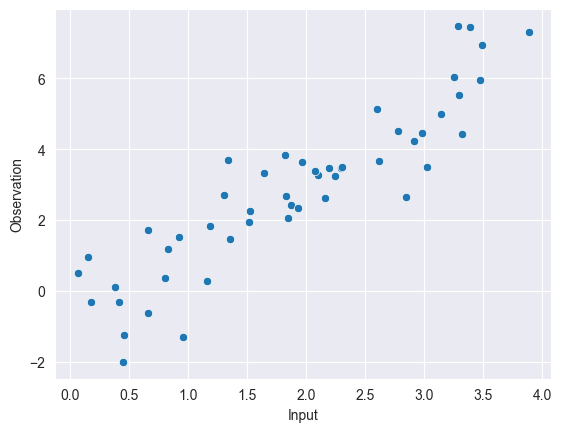

In [55]:
beta_0_true = -1
beta_1_true = 2
tau_true = 1

N = 50
x = np.random.uniform(0, 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

plot_df = pd.DataFrame({"Input": x, "Observation": y})

ground_truth_plot = sns.scatterplot(x = "Input", y = "Observation", data = plot_df).plot()

Now we can set up our Gibbs Sampler. Let's assume a Normal distribution on both Beta parameters of N(0,1).

Let's assume a gamma distribution of G(2,1)



In [56]:
init = {
    "beta_0": 0,
    "beta_1": 0,
    "tau": 2
}

#Add quotation marks to the keys of the dictionary

hypers = {
    "mu_0": 0,
    "tau_0": 1,
    "mu_1": 0,
    "tau_1": 1,
    "alpha": 2,
    "beta": 1
}

In [57]:
#Define gibbs sampler

def gibbs(x, y, iters, init, hyper):
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]

    #Create a record of all sampled values
    trace = np.zeros((iters, 3))

    for i in range(iters):
        #Sample beta_0
        beta_0 = sample_beta_0_marg_post(x, y, beta_1, tau, hyper["tau_0"], hyper["mu_0"])
        #Sample beta_1
        beta_1 = sample_beta_1_marg_post(x, y, beta_0, tau, hyper["tau_1"], hyper["mu_1"])
        #Sample tau
        tau = sample_tau_marg_post(x, y, beta_0, beta_1, hyper["alpha"], hyper["beta"])
        #Save sampled values in trace
        trace[i,:] = np.array((beta_0, beta_1, tau))

    #Save trace in df
    trace_df = pd.DataFrame(trace, columns = ["beta_0", "beta_1", "tau"])

    return trace_df


In [58]:
#Run gibbs sampler
iters = 1000
trace = gibbs(x, y, iters, init, hypers)

Text(0, 0.5, 'Parameter value')

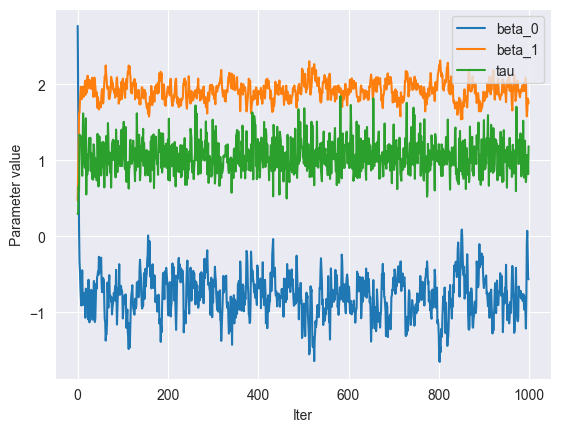

In [59]:
#Plot trace
trace_plot = trace.plot()
trace_plot.set_xlabel("Iter")
trace_plot.set_ylabel("Parameter value")

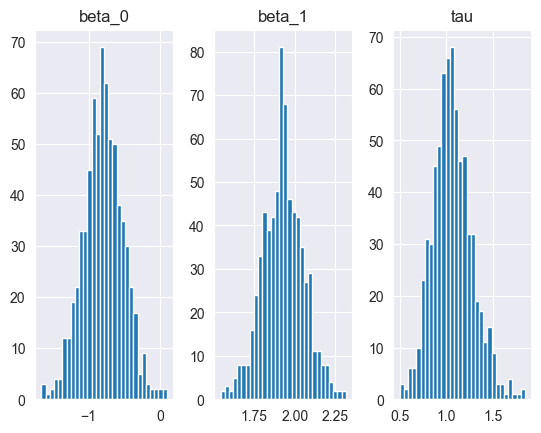

In [63]:
#Define trace after burn in period of ~300 iterations
trace_after_burnin = trace[300:]
hist_plot = trace_after_burnin.hist(bins = 30, layout = (1,3))

In [64]:
#Print median and std values of burnin
print(trace_after_burnin.median())
print(trace_after_burnin.std())

beta_0   -0.799336
beta_1    1.924471
tau       1.043920
dtype: float64
beta_0    0.277902
beta_1    0.128348
tau       0.214166
dtype: float64
